# Analysis of video comments on YouTube

In [1]:
import numpy as np 
import pandas as pd 
import re
import nltk
from nltk.corpus import abc
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.snowball import *
from nltk.util import ngrams
import string
import spacy
from spacy import displacy
from spacy_langdetect import LanguageDetector
from autocorrect import Speller
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.models.word2vec import Text8Corpus
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob import Word
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
sp = spacy.load('en_core_web_sm')

In [4]:
spacy_sw = sp.Defaults.stop_words # Spacy: 326

In [5]:
nltk_sw = stopwords.words('english') #NLTK: 179

In [6]:
len(list(STOPWORDS)) # wordcloud STOPWORDS: 192

192

In [7]:
stop_words = list(spacy_sw) + list(nltk_sw) + list(STOPWORDS)

In [8]:
len(stop_words)

697

In [9]:
stop_words = list(dict.fromkeys(stop_words))

In [10]:
print(f'The total number of StopWords made up of combining the 3 libraries is: {len(stop_words)} words.')

The total number of StopWords made up of combining the 3 libraries is: 418 words.


In [11]:
def f_clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

clean_text = lambda x: f_clean_text(x)

In [12]:
spell = Speller()

def cross_talk(txt):
    ret = 'none'
    pattern = r'\[.*?\]'
    if re.findall(pattern, txt):
        ret = re.findall(pattern, txt)
    return ret

def removing(txt):
    pattern = r'\[.*?\]'
    return re.sub(pattern, '', txt)
nawiasy = lambda x: removing(x)

def all_sentences(txt):
    return len(TextBlob(txt).sentences)
zdania = lambda x: all_sentences(x)

def all_words(txt):
    return len(TextBlob(txt).words)
slowa = lambda x: all_words(x)

def correct_word(txt):
    corr = ''
    corr_words=[]
    txt = word_tokenize(txt) 
    for word in txt:
        corr_words.append(spell(word))
    corr = ' '.join([w for w in corr_words])
    return corr
correct = lambda x: correct_word(x)

def f_lemat(sentence, stem=False, lemmatize=True):
    s = sentence.lower()
    s = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', ' ', s)
    #usuwam []
    
    s = re.sub('\n', ' ', s)
    s = re.sub('<.*?>',' ',s)
    s = re.sub('\[.*?\]',' ', s)
    
    # usuwam wszystkie znaki oprócz liter
    s = re.sub('[%s]' % re.escape(string.punctuation), ' ', s)
    s = re.sub('\w*\d\w*', ' ', s)
    s = re.sub('[‘’“”…]', ' ', s)
    
    s = re.sub('[^a-zA-Z]', ' ', s)
    # tokenizuję
    s = word_tokenize(s) 

    clear_post = []
    for word in s:
        if (not word in stop_words) and (len(word)>2):
                if stem:
                    clear_post.append(porter_stremmer.stem(word))
                elif lemmatize:
                    clear_post.append(Word(word, pos_tag='a').lemmatize())
                else:
                    clear_post.append(word)
        
    lemmatized_output = ' '.join([w for w in clear_post])
    
    return lemmatized_output

In [13]:
df = pd.read_pickle('YT_po_lematyzacji.pkl')
df.shape

(3407, 15)

In [14]:
# drop duplicates
df.drop_duplicates(subset='comment',keep='last',inplace=True)
df.shape

(3407, 15)

In [15]:
df.reply_count = df.reply_count.astype(int)
df.like_count = df.like_count.astype(int)

In [16]:
df.videoId.nunique()

1109

In [17]:
print(f'The number of comments: {df.shape[0]}\nThe number of videos: {df.videoId.nunique()}\nNumber of unique authors of comments: {df.author.nunique()}')

The number of comments: 3407
The number of videos: 1109
Number of unique authors of comments: 2970


In [19]:
print(f'Maximum number of responses: {df.reply_count.max()}\nMinimum number of responses: {df.reply_count.min()}\nAverage number of responses: {df.reply_count.mean()}\nMedian number of responses: {df.reply_count.median()}')

Maximum number of responses: 500
Minimum number of responses: 0
Average number of responses: 20.60228940416789
Median number of responses: 0.0


In [20]:
print(f'Maximum number of likes: {df.like_count.max()}\nMinimum likes: {df.like_count.min()}\nAverage number of likes: {df.like_count.mean()}\nMedian number of likes: {df.like_count.median()}')

Maximum number of likes: 52759
Minimum likes: 0
Average number of likes: 302.86586439683003
Median number of likes: 1.0


In [21]:
likes = df.sort_values(by='like_count',ascending=False).reset_index()

In [22]:
likes.drop(['index'],inplace=True,axis=1)

In [23]:
likes

,published_time,author,comment,reply_count,like_count,videoId,videotitle,videotimepublished,language,lang_score,clean_text,correct,words,polarity,subjectivity
0,2021-01-21 23:20:40+00:00,Dr. Beau Hightower,Wow. That guy actually made sense.,465,52759,xL_hnA2u-SA,We Spoke to a Lone Trump Supporter at Biden&#3...,2021-01-21 22:30:08+00:00,en,0.857141,wow guy actually sense,wow guy actually sense,6,0.050000,0.550000
1,2020-04-09 15:51:45+00:00,KM,Problem isnt the brits who are surprised. The ...,495,44603,Kll-yYQwmuM,True cost of US healthcare shocks the British ...,2019-12-03 14:48:16+00:00,en,0.999996,problem isnt brit surprised true problem ameri...,problem isnt brit surprised true problem ameri...,14,0.225000,0.775000
2,2019-11-25 12:52:55+00:00,John Valdes,"Even in a fake debate, Andrew Yang cant get an...",302,24103,y8EQFhj8ca4,2020 Democratic Debate - SNL,2019-11-24 08:47:25+00:00,en,0.999996,fake debate andrew yang cant airtime,fake debate andrew yang cant airtime,11,-0.500000,1.000000
3,2020-10-01 11:32:09+00:00,CNDBLOOD,Wait so this isnt a meme edit?,154,23881,oXOlvWw8uXs,US candidate Joe Biden dances to mega-hit &#39...,2020-09-16 13:28:11+00:00,en,0.999998,wait isnt meme edit,wait isnt meme edit,7,0.000000,0.000000
4,2020-11-09 20:37:52+00:00,Recker,“Never underestimate the power of stupid peopl...,454,23064,mc7_GzMOodY,These Trump supporters think the election was ...,2020-11-09 20:29:05+00:00,en,0.999997,underestimate power stupid people large group ...,underestimate power stupid people large group ...,14,-0.292857,0.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,2020-11-03 03:24:37+00:00,Kyle Jackson,Trafalgar is a Republican pollster whose goal ...,0,0,bdzBalc1uVs,Pollster Who Correctly Predicted 2016 Discusse...,2020-11-03 01:29:26+00:00,en,0.999997,trafalgar republican pollster goal pretend don...,trafalgar republican poster goal pretend donal...,137,-0.013187,0.552381
3403,2020-11-25 11:36:42+00:00,BLACK NAP0LE0N,Make no mistake... Donald Trump was legitimate...,0,0,LXsiYZERYCk,It is clear &#39;something fishy&#39; took pla...,2020-11-25 10:45:26+00:00,en,0.999996,mistake donald trump legitimately voted presid...,mistake donald trump legitimately voted presid...,91,0.200000,0.644444
3404,2020-11-25 12:06:09+00:00,TheKira699,"Let\s face it, Donald Trump had a woeful turn ...",0,0,LXsiYZERYCk,It is clear &#39;something fishy&#39; took pla...,2020-11-25 10:45:26+00:00,en,0.999998,let face donald trump woeful turn people sick ...,let face donald trump useful turn people sick ...,245,-0.052381,0.448095
3405,2020-11-08 06:27:21+00:00,Ben Main,Just give it up. The Trump campaign barely has...,1,0,MW63gVirPNs,ELECTION 2020: Trump Campaign Scores Another W...,2020-11-06 21:34:09+00:00,en,0.999998,trump campaign barely support gop point wonder...,trump campaign barely support gop point wonder...,118,0.108333,0.583333


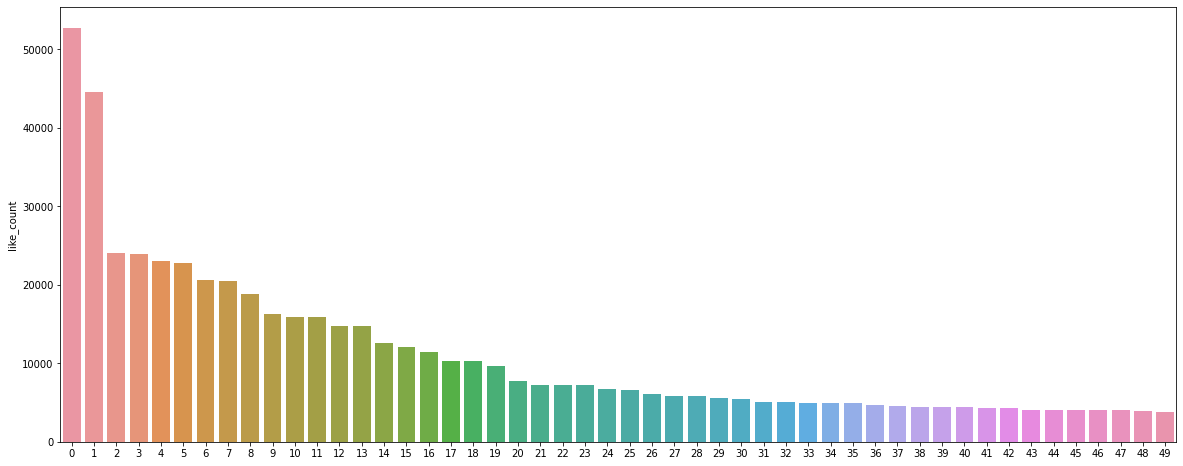

In [24]:
plt.figure(figsize=(20,8))
sns.barplot(data=likes[:50],x=likes.index[:50],y='like_count');

In [25]:
replies = df.sort_values(by='reply_count',ascending=False).reset_index()
replies.drop(['index'],inplace=True,axis=1)

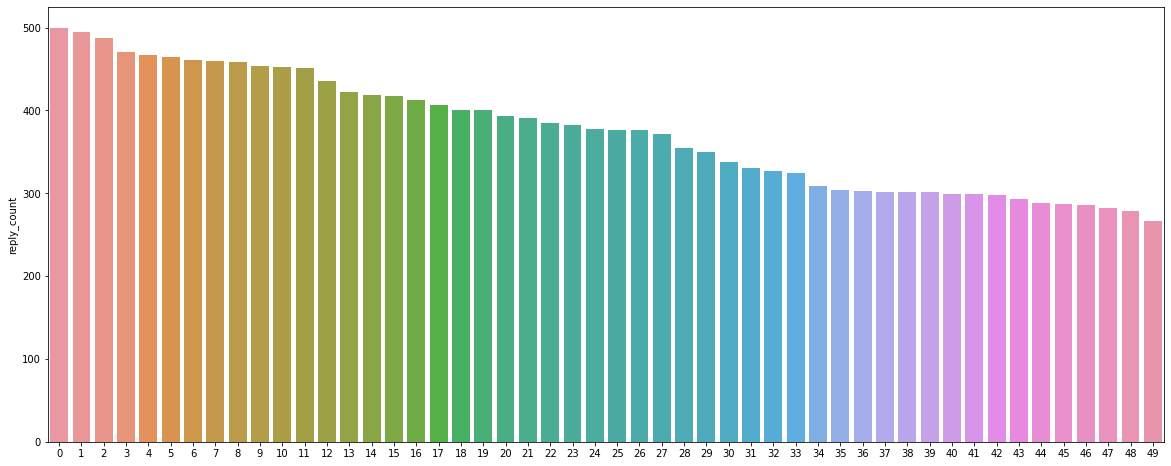

In [26]:
plt.figure(figsize=(20,8))
sns.barplot(data=replies[:50],x=replies.index[:50],y='reply_count');

### Language detection

In [27]:
from spacy.language import Language
from spacy_langdetect import LanguageDetector

In [28]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

In [29]:
Language.factory("language_detector", func=get_lang_detector)
sp.add_pipe('language_detector', last=True)

In [30]:
def detect_lang(text_content):
    doc = sp(text_content) 
    detect_language = doc._.language 
    return detect_language['language'], detect_language['score']

In [31]:
df['language'], df['lang_score'] = zip(*[ detect_lang(x) for x in df.comment ])

In [32]:
df.language.unique()

array(['en', 'nl', 'da', 'af', 'de', 'ca', 'es'], dtype=object)

### Elimination of comments in languages other than English

In [33]:
non_eng=[]
for x in df.language.unique():
    if x != 'en':
        for s in df[df.language==x].index:
            non_eng.append(s)

In [34]:
print(non_eng)

[48, 62, 150, 514, 1615, 1705, 2439, 2608, 2669, 2713, 2779, 3483, 3587, 3612, 53, 72, 98, 532, 1310, 2121, 2616, 3844, 4327, 69, 77, 235, 257, 767, 893, 1254, 1826, 2638, 3077, 3839, 149, 365, 781, 1140, 2178, 279, 1762, 2177, 2690, 3985]


In [35]:
df.drop([48, 62, 150, 514, 1615, 1705, 2439, 2608, 2669, 2713, 2779, 3483, 3587, 3612, 53, 72, 98, 532, 1310, 2121, 2616, 3844, 4327, 69, 77, 235, 257, 767, 893, 1254, 1826, 2638, 3077, 3839, 149, 365, 781, 1140, 2178, 279, 1762, 2177, 2690, 3985],inplace=True)

In [36]:
df

,published_time,author,comment,reply_count,like_count,videoId,videotitle,videotimepublished,language,lang_score,clean_text,correct,words,polarity,subjectivity
46,2020-11-13 07:24:44+00:00,Peoples voice,"US elections 2020 Joe Biden vs Donald Trump,ht...",0,0,UCA1A5GqCdQ,Final 2020 Presidential Debate Between Donald ...,2020-10-23 03:20:53+00:00,en,0.714283,election joe biden donald trump,election joe biden donald trump,11,0.000000,0.000000
47,2020-11-10 03:59:37+00:00,Peoples voice,US elections 2020 Joe Biden vs Donald Trump\nh...,0,0,UCA1A5GqCdQ,Final 2020 Presidential Debate Between Donald ...,2020-10-23 03:20:53+00:00,en,0.999995,election joe biden donald trump nhttps,election joe biden donald trump https,11,0.000000,0.000000
49,2020-11-04 00:11:51+00:00,Eric Irizarry,"Trump has always been loyal, and I stand by him.",4,0,UCA1A5GqCdQ,Final 2020 Presidential Debate Between Donald ...,2020-10-23 03:20:53+00:00,en,0.999995,trump loyal stand,trump loyal stand,10,0.333333,0.833333
50,2020-11-03 22:04:55+00:00,HearthTheSkyWing XD,everyone for the election JOE BIDEN or DONALD ...,13,43,UCA1A5GqCdQ,Final 2020 Presidential Debate Between Donald ...,2020-10-23 03:20:53+00:00,en,0.999997,election joe biden donald trump nthe candidate,election joe biden donald trump the candidate,14,-0.125000,0.375000
51,2020-11-03 16:11:40+00:00,Karen ._Yass,And every thing Donald J Trump is saying about...,1,0,UCA1A5GqCdQ,Final 2020 Presidential Debate Between Donald ...,2020-10-23 03:20:53+00:00,en,0.999996,thing donald trump saying lie possibly possibl...,thing donald trump saying lie possibly possibl...,188,0.145000,0.558333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,2020-11-07 19:21:48+00:00,Majestic,"Firstly, we need to understand: unsolicited ba...",0,0,KravPVeqTCc,Joe Biden defeats Donald Trump to become 46th ...,2020-11-07 16:55:00+00:00,en,0.999998,firstly need understand unsolicited ballot mai...,firstly need understand unsolicited ballot mai...,315,0.024449,0.584283
4422,2020-11-07 18:15:59+00:00,Jay H,"Oh no, Fox is calling Joe Biden president elec...",0,0,KravPVeqTCc,Joe Biden defeats Donald Trump to become 46th ...,2020-11-07 16:55:00+00:00,en,0.999997,fox calling joe biden president elect ignoring...,fox calling joe biden president elect ignoring...,21,1.000000,0.900000
4423,2020-11-07 18:05:39+00:00,Michael,We all know why Joe Biden is rushing to falsel...,0,0,KravPVeqTCc,Joe Biden defeats Donald Trump to become 46th ...,2020-11-07 16:55:00+00:00,en,0.999995,know joe biden rushing falsely pose winner med...,know joe biden rushing falsely pose winner med...,259,0.048623,0.499151
4424,2020-11-07 17:20:35+00:00,Vesa Kaitera,"I is highly likely, that Joe Biden will win, b...",2,9,KravPVeqTCc,Joe Biden defeats Donald Trump to become 46th ...,2020-11-07 16:55:00+00:00,en,0.999995,highly likely joe biden win point wait thing d...,highly likely joe biden win point wait thing d...,158,0.363182,0.550000


### Data cleansing

In [37]:
df['clean_text'] = df.comment.apply(lambda x: f_lemat(x))

In [38]:
df['words'] = df.comment.apply(slowa)

In [39]:
print(f'Maximum number of words: {df.words.max()}\nThe minimum number of words: {df.words.min()}\nAverage word count: {df.words.mean()}\nMedian number of words: {df.words.median()}')

Maximum number of words: 1771
The minimum number of words: 3
Average word count: 141.25661611656258
Median number of words: 45.0


In [40]:
words = df.sort_values(by='words',ascending=False).reset_index()
words.drop(['index'],inplace=True,axis=1)

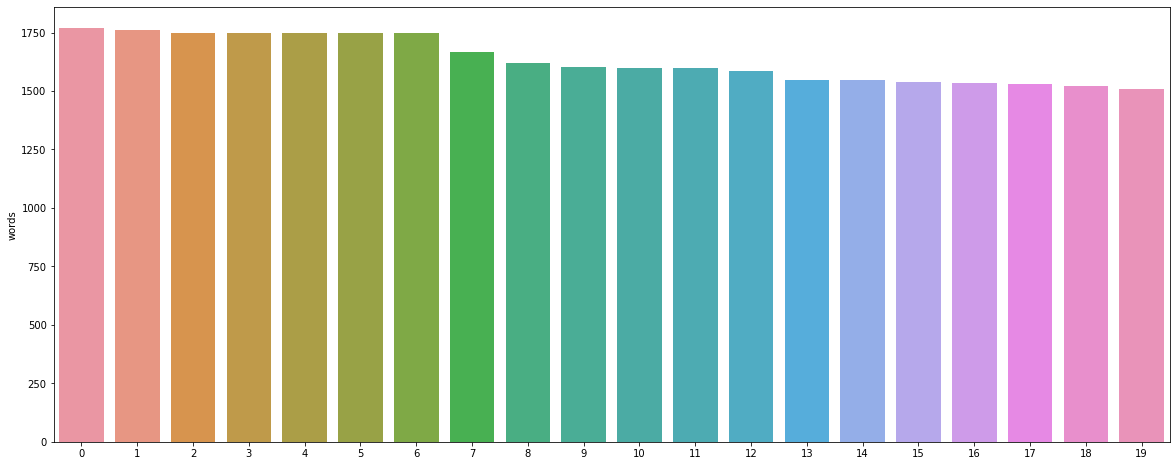

In [41]:
plt.figure(figsize=(20,8))
sns.barplot(data=words[:20],x=words.index[:20],y='words');

In [42]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
reply_count,3363.0,20.720488,58.064902,0.00000,0.000000,0.000000,10.000000,500.0
like_count,3363.0,305.573892,1840.214820,0.00000,0.000000,1.000000,40.000000,52759.0
lang_score,3363.0,0.994787,0.040067,0.42857,0.999996,0.999997,0.999998,1.0
words,3363.0,141.256616,251.356197,3.00000,19.000000,45.000000,138.000000,1771.0
polarity,3363.0,0.077836,0.262246,-1.00000,-0.003238,0.047161,0.183547,1.0
subjectivity,3363.0,0.433429,0.257796,0.00000,0.300000,0.450000,0.575000,1.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3363 entries, 46 to 4425
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   published_time      3363 non-null   datetime64[ns, UTC]
 1   author              3363 non-null   object             
 2   comment             3363 non-null   object             
 3   reply_count         3363 non-null   int32              
 4   like_count          3363 non-null   int32              
 5   videoId             3363 non-null   object             
 6   videotitle          3363 non-null   object             
 7   videotimepublished  3363 non-null   datetime64[ns, UTC]
 8   language            3363 non-null   object             
 9   lang_score          3363 non-null   float64            
 10  clean_text          3363 non-null   object             
 11  correct             3363 non-null   object             
 12  words               3363 non-null

In [44]:
df.dtypes

published_time        datetime64[ns, UTC]
author                             object
comment                            object
reply_count                         int32
like_count                          int32
videoId                            object
videotitle                         object
videotimepublished    datetime64[ns, UTC]
language                           object
lang_score                        float64
clean_text                         object
correct                            object
words                               int64
polarity                          float64
subjectivity                      float64
dtype: object

In [45]:
#df.to_pickle('YT_po_lematyzacji.pkl')

In [46]:
df = pd.read_pickle('YT_po_lematyzacji.pkl')

In [47]:
sentences = df.correct.values

In [49]:
word_count = {}
text = ''

for tokens in sentences:
    for word in word_tokenize(tokens):

        if word not in word_count.keys():
            word_count[word] = 1
        else:
            word_count[word] += 1
    text += ''.join(tokens)

In [50]:
len(word_count)

12768

In [51]:
len(word_tokenize(text))

224279

In [52]:
len(TextBlob(text).words)

224279

## Sentiment analysis

### Polarization of speech

In [53]:
polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

In [54]:
def sentiment(x):
    if x>0:
        return 'positive'
    if x<0:
        return 'negative'
    if x==0:
        return 'neutral'

In [55]:
df['polarity'] = df.comment.apply(polarity)
df['subjectivity'] = df.comment.apply(subjectivity)

In [56]:
df['sentiment'] = df.polarity.apply(lambda x: sentiment(x))

In [57]:
df.head(3)

,published_time,author,comment,reply_count,like_count,videoId,videotitle,videotimepublished,language,lang_score,clean_text,correct,words,polarity,subjectivity,sentiment
46,2020-11-13 07:24:44+00:00,Peoples voice,"US elections 2020 Joe Biden vs Donald Trump,ht...",0,0,UCA1A5GqCdQ,Final 2020 Presidential Debate Between Donald ...,2020-10-23 03:20:53+00:00,en,0.999993,election joe biden donald trump,election joe biden donald trump,11,0.0,0.0,neutral
47,2020-11-10 03:59:37+00:00,Peoples voice,US elections 2020 Joe Biden vs Donald Trump\nh...,0,0,UCA1A5GqCdQ,Final 2020 Presidential Debate Between Donald ...,2020-10-23 03:20:53+00:00,en,0.714283,election joe biden donald trump nhttps,election joe biden donald trump https,11,0.0,0.0,neutral
48,2020-11-06 16:50:01+00:00,Sean Simmons,Vote joe Biden Not Donald Trump,0,0,UCA1A5GqCdQ,Final 2020 Presidential Debate Between Donald ...,2020-10-23 03:20:53+00:00,nl,0.999995,vote joe biden donald trump,vote joe biden donald trump,6,0.0,0.0,neutral


In [58]:
df.author.nunique()

2970

In [59]:
for x in range(0,len(df.author.value_counts())):
    if df.author.value_counts()[x]>5:   
        print(df.author.value_counts().index[x],'\n',df[df.author==df.author.value_counts().index[x]]['sentiment'].value_counts())

Abner Rigaud 
 positive    30
Name: sentiment, dtype: int64
Myanmar AHla 
 positive    28
Name: sentiment, dtype: int64
Mark Gazel 
 positive    14
negative     8
Name: sentiment, dtype: int64
Michael 
 negative    8
positive    8
Name: sentiment, dtype: int64
Brad Hartliep 
 positive    9
negative    5
Name: sentiment, dtype: int64
Dave Mock 
 positive    14
Name: sentiment, dtype: int64
abdenbi CHIKOUN 
 neutral     5
negative    4
positive    3
Name: sentiment, dtype: int64
Roman Vomalsi 
 negative    3
positive    3
neutral     2
Name: sentiment, dtype: int64
Harry Steele 
 positive    6
negative    1
Name: sentiment, dtype: int64
Patrick Glass 
 positive    4
negative    3
Name: sentiment, dtype: int64
Mark Cicero 
 positive    6
neutral     1
Name: sentiment, dtype: int64
MR. NOBODY 
 positive    4
negative    2
Name: sentiment, dtype: int64
Joseph jo 
 positive    5
negative    1
Name: sentiment, dtype: int64
Dilip Patel 
 positive    6
Name: sentiment, dtype: int64
Toni Olson 


In [60]:
df[df.author=='Abner Rigaud']['sentiment'].value_counts()

positive    30
Name: sentiment, dtype: int64

In [61]:
df[(df.author=='Myanmar AHla')]['sentiment'].value_counts()

positive    28
Name: sentiment, dtype: int64

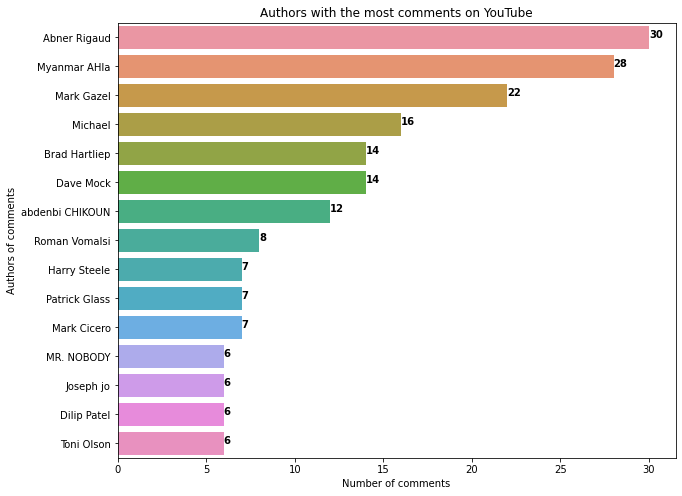

In [63]:
bar,ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=df.author.value_counts()[:15],y=df.author.value_counts().index[:15])
ax.set_title('Authors with the most comments on YouTube')
ax.set_xlabel ("Number of comments")
ax.set_ylabel ("Authors of comments")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.0f"% rect.get_width(), weight='bold' )

In [64]:
def sent(x):
    if x>0:
        return 'positive'
    if x<0:
        return 'negative'
    if x==0:
        return 'neutral'

In [65]:
df['sentiment'] = df.polarity.apply(lambda x: sent(x) )

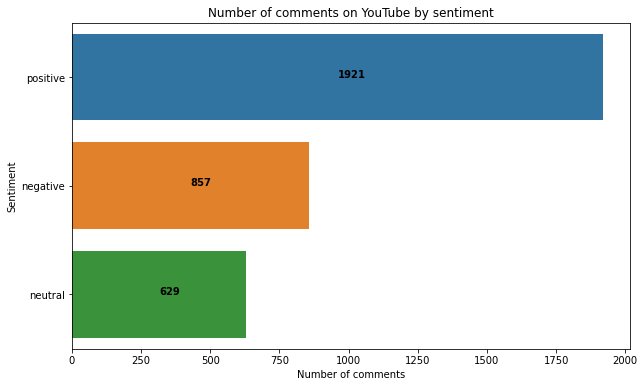

In [66]:
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=df.sentiment.value_counts(),y=df.sentiment.value_counts().index);
ax.set_title('Number of comments on YouTube by sentiment')
ax.set_xlabel ("Number of comments")
ax.set_ylabel ("Sentiment")
for rect in ax.patches:
    ax.text (rect.get_width()/2, rect.get_y() + rect.get_height() / 2,"%.0f"% rect.get_width(), weight='bold' )

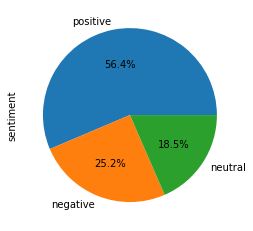

In [67]:
df.sentiment.value_counts().plot(kind='pie', autopct="%.1f%%");

In [68]:
df.columns

Index(['published_time', 'author', 'comment', 'reply_count', 'like_count',
       'videoId', 'videotitle', 'videotimepublished', 'language', 'lang_score',
       'clean_text', 'correct', 'words', 'polarity', 'subjectivity',
       'sentiment'],
      dtype='object')

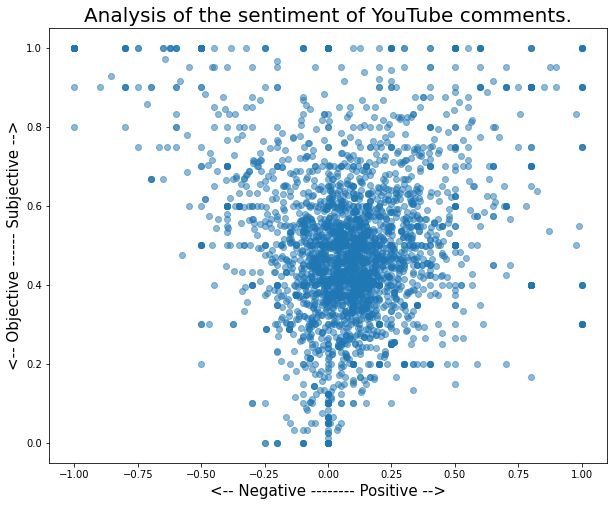

In [69]:
plt.rcParams['figure.figsize'] = [10, 8]

plt.scatter(df.polarity, df.subjectivity,alpha=.5) 
plt.title('Analysis of the sentiment of YouTube comments.', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Objective ------ Subjective -->', fontsize=15)

plt.show()